In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, optimize

## Define the parameters of the experiment
For the purpose of illustration, we also assume we know the "true" value of the survival probability, p_s

In [2]:
N_well = 96
p_s    = 0.4
n0     = 50

### Probability that a well will have zero surviving cells:

In [3]:
def p0(p_s, n0, N_well):
    return np.exp(-p_s*n0/N_well)

In [4]:
N_dead_expected = N_well * p0(p_s, n0, N_well)
print("Expected value of N_dead = %.2f"%N_dead_expected)

Expected value of N_dead = 77.95


In [5]:
N_dead = np.random.binomial(N_well, p0(p_s, n0, N_well))
print("Randomly-chosen value for N_dead: %d"%N_dead)

Randomly-chosen value for N_dead: 76


### Randomly sample from the binomial distribution for this experiment
We have chosen one specific value at random to represent our actual "observation"

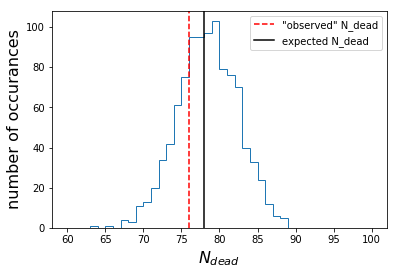

In [6]:
plt.hist(np.random.binomial(N_well, p0(p_s, n0, N_well), size=1000), histtype='step', bins=40, range=(60,100));
plt.axvline(N_dead, linestyle='--', color='red', label='"observed" N_dead');
plt.axvline(N_dead_expected, color='black', label='expected N_dead');
plt.xlabel("$N_{dead}$", fontsize=16);
plt.ylabel("number of occurances", fontsize=16);
plt.legend();

### Construct likelihood function
Note that in practice, one miniimzes the negative logarithm likelihood, rather than maximizing the lhood directly.
Also note that this is a function that takes the "observed" value and returns another function of the proposed survival probability.

In [7]:
def make_nll(N_dead):
    def fn(p):
        return -2*stats.binom.logpmf(N_dead, N_well, p0(p, n0, N_well))
    return fn

In [8]:
observed_nll = make_nll(N_dead)

### Minimize -2ln(L)
The value of p_s which minimizes -2ln(L) for our "observation" is the maximum likelihood estimate of this parameter for the experiment.

In [9]:
result = optimize.minimize(observed_nll, x0=0.5, bounds=[(1e-2,1)])
p_s_estimate = result.x[0]
print("Maximum likelihood estimate for p_s: %.2f"%p_s_estimate)

Maximum likelihood estimate for p_s: 0.45


### Plot -2ln(L)
Vertical bars show our maximum likelihood estimate (red) along with the true value (black).
If you repeat the experiment by drawing a different random value of N_draw, this estimate will move around but on average should give the true value!

Note that if you change the parameters of the experiment (e.g. n0, N_well), you can make the likelihood function "steeper", which gives greater precision in the final estimate.

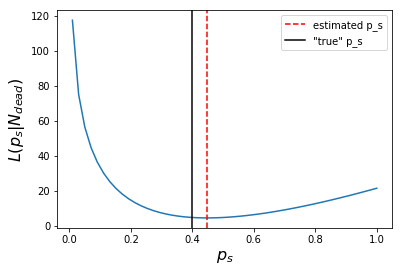

In [10]:
x_values = np.linspace(1e-2,1.0,50)
plt.plot(x_values, observed_nll(x_values));
plt.axvline(p_s_estimate, linestyle='--', color='red', label='estimated p_s');
plt.axvline(p_s, color='black', label='"true" p_s');
plt.xlabel("$p_s$", fontsize=16);
plt.ylabel("$L(p_s | N_{dead})$", fontsize=16);
plt.legend();

## Example combining two experiments, with different concentrations of cell A and B

In [11]:
p_A = 0.4
p_B = 0.1

n0_A = 50*0.65
n0_B = 50*0.35

n1_A = 0
n1_B = 50

## Probability that a well has no surviving cells
Note this now depends on more parameters of the experiment.

In [12]:
def p0_mix(p_A, p_B, n_A, n_B, N_well):
    return np.exp(-(p_A*n_A + p_B*n_B)/N_well)

In [13]:
N0_dead_expected = N_well * p0_mix(p_A, p_B, n0_A, n0_B, N_well)
print("expected value of N_dead(0) = %.2f"%N0_dead_expected)
N1_dead_expected = N_well * p0_mix(p_A, p_B, n1_A, n1_B, N_well)
print("expected value of N_dead(1) = %.2f"%N1_dead_expected)

expected value of N_dead(0) = 82.33
expected value of N_dead(1) = 91.13


### Grab two values of N_dead
This represents doing the experiment twice, note that each experiment has its own, different parameters (i.e. the concentrations).

In [14]:
N0_dead = np.random.binomial(N_well, p0_mix(p_A, p_B, n0_A, n0_B, N_well))
N1_dead = np.random.binomial(N_well, p0_mix(p_A, p_B, n1_A, n1_B, N_well))
print("Randomly-chosen value of N_dead(0): %d"%N0_dead)
print("Randomly-chosen value of N_dead(1): %d"%N1_dead)

Randomly-chosen value of N_dead(0): 79
Randomly-chosen value of N_dead(1): 94


## Combined likelihood
Note that in order to combine the results from two experiments, you just have to multiply the likelihoods together (or add the logarithms).

Note also that the NLL depends on _two_ observations, one from each experiment.

In [15]:
def make_nll_mix(obs0, obs1):
    def fn(p):
        p_a = p[0]
        p_b = p[1]
        return -2*(
            stats.binom.logpmf(obs0, N_well, p0_mix(p_a, p_b, n0_A, n0_B, N_well)) +
            stats.binom.logpmf(obs1, N_well, p0_mix(p_a, p_b, n1_A, n1_B, N_well))
        )
    return fn

In [16]:
observed_nll_mix = make_nll_mix(N0_dead, N1_dead)

### Minimize -2ln(L) in the 2-dimensional parameter space of (p_A,p_B)

In [17]:
result = optimize.minimize(observed_nll_mix, x0=(0.5, 0.5), bounds=[(1e-2,1), (1e-2, 1)])
p_A_estimate = result.x[0]
p_B_estimate = result.x[1]
print("Maximum likelihood estimate for p_A: %.2f"%p_A_estimate)
print("Maximum likelihood estimate for p_B: %.2f"%p_B_estimate)

Maximum likelihood estimate for p_A: 0.55
Maximum likelihood estimate for p_B: 0.04


### Contour plot of the 2-dimensional likelihood
Again, the "steeper" the bottom of this contour is (in both dimensions), the more precise the measurement.
Sometimes one variable is well defined while the other is not, giving an oblong contour lines.

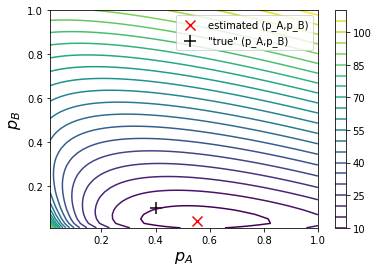

In [18]:
X, Y = np.meshgrid(np.linspace(1e-2,1), np.linspace(1e-2,1))
c = plt.contour(X,Y,observed_nll_mix([X,Y]), 25)
plt.scatter(p_A_estimate, p_B_estimate, marker='x', color='red', s=100, label='estimated (p_A,p_B)')
plt.scatter(p_A, p_B, marker='+', color='black', s=150, label='"true" (p_A,p_B)');
plt.xlabel("$p_A$", fontsize=16)
plt.ylabel("$p_B$", fontsize=16)
plt.legend();
plt.colorbar(c);